In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

os.chdir("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from src.datasets.datasets import AllModelsOutputDataset, CPDDatasets
from src.ensembles.ensembles import EnsembleCPDModel
from src.metrics.evaluation_pipelines import (
    evaluate_distance_ensemble_model,
)
from src.metrics.metrics_utils import collect_model_predictions_on_set
from src.utils.calibration import (
    calibrate_all_models_in_ensemble,
)
from src.utils.fix_seeds import fix_seeds
from torch.utils.data import DataLoader

SEED = 42
fix_seeds(SEED)

%load_ext autoreload
%autoreload
%matplotlib inline

comet_ml is installed but `COMET_API_KEY` is not set.


# max F1 vs Wasserstein threshold

# HAR

In [3]:
model_type = "seq2seq"

experiments_name = "human_activity"
path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/human_activity/full_sample/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [88]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

In [89]:
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cpu",
    verbose=False,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)

out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

res_start, best_th_start = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="start",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

res_prev, best_th_prev = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/102 [00:00<?, ?it/s]

Results for best threshold = 0.31917282672147035
AUDC: 0.0, Time to FA: 11.2012, DD: 1.1264, F1: 0.975, Cover: 0.9103, Max Cover: 0.9103
Max F1 with margin 1: 0.9357
Max F1 with margin 2: 0.9682
Max F1 with margin 4: 0.9704


100%|██████████| 102/102 [03:05<00:00,  1.82s/it]

Results for best threshold = 0.2571936527643822
AUDC: 0.0, Time to FA: 11.1675, DD: 1.1122, F1: 0.9745, Cover: 0.9114, Max Cover: 0.9114
Max F1 with margin 1: 0.943
Max F1 with margin 2: 0.9682
Max F1 with margin 4: 0.9714


In [65]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])
outs_tensor.shape, labels_tensor.shape

(torch.Size([10, 1337, 20]), torch.Size([1337, 20]))

In [66]:
torch.save(outs_tensor, "saved_outputs/bce/human_activity/all_models_ens_1_outputs.pt")
torch.save(labels_tensor, "saved_outputs/bce/human_activity/all_models_ens_1_labels.pt")

In [90]:
f1_dict_start = {th: v[3] for th, v in res_start.items()}
f1_m2_list_start = {th: v[6][2] for th, v in res_start.items()}

f1_dict_prev = {th: v[3] for th, v in res_prev.items()}
f1_m2_list_prev = {th: v[6][2] for th, v in res_prev.items()}

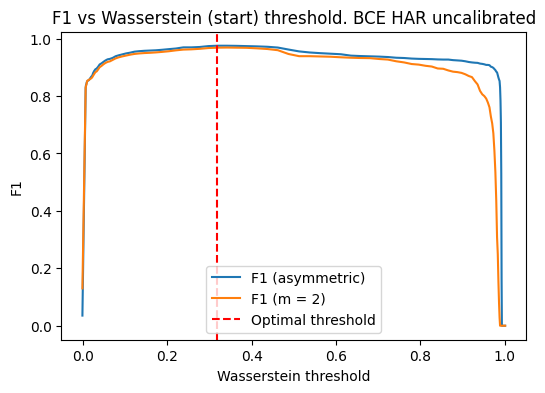

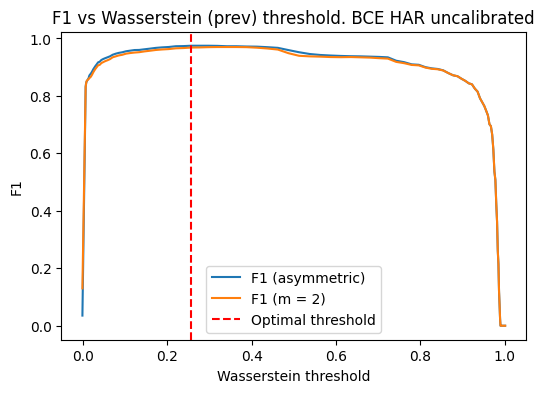

In [91]:
plt.figure(figsize=(6, 4))
plt.plot(f1_dict_start.keys(), f1_dict_start.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_start.keys(), f1_m2_list_start.values(), label="F1 (m = 2)")
plt.axvline(best_th_start, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title("F1 vs Wasserstein (start) threshold. BCE HAR uncalibrated", fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_prev.keys(), f1_dict_prev.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_prev.keys(), f1_m2_list_prev.values(), label="F1 (m = 2)")
plt.axvline(best_th_prev, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title("F1 vs Wasserstein (prev) threshold. BCE HAR uncalibrated", fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [92]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    cal_type="beta",
    verbose=False,
    device="cpu",
)

test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cpu",
    verbose=False,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)

out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

res_start_cal, best_th_start_cal = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="start",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

res_prev_cal, best_th_prev_cal = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/102 [00:00<?, ?it/s]

Results for best threshold = 0.34151151059747936
AUDC: 0.0, Time to FA: 11.2281, DD: 1.1429, F1: 0.9754, Cover: 0.9096, Max Cover: 0.9096
Max F1 with margin 1: 0.9288
Max F1 with margin 2: 0.9686
Max F1 with margin 4: 0.97


100%|██████████| 102/102 [02:47<00:00,  1.64s/it]

Results for best threshold = 0.27695909778815886
AUDC: 0.0, Time to FA: 11.2034, DD: 1.1212, F1: 0.9759, Cover: 0.9119, Max Cover: 0.9119
Max F1 with margin 1: 0.9415
Max F1 with margin 2: 0.9695
Max F1 with margin 4: 0.9732


In [69]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])
outs_tensor.shape, labels_tensor.shape

(torch.Size([10, 1337, 20]), torch.Size([1337, 20]))

In [70]:
torch.save(
    outs_tensor, "saved_outputs/bce/human_activity/all_models_ens_1_outputs_cal.pt"
)
torch.save(
    labels_tensor, "saved_outputs/bce/human_activity/all_models_ens_1_labels_cal.pt"
)

In [93]:
f1_dict_start_cal = {th: v[3] for th, v in res_start_cal.items()}
f1_m2_list_start_cal = {th: v[6][2] for th, v in res_start_cal.items()}

f1_dict_prev_cal = {th: v[3] for th, v in res_prev_cal.items()}
f1_m2_list_prev_cal = {th: v[6][2] for th, v in res_prev_cal.items()}

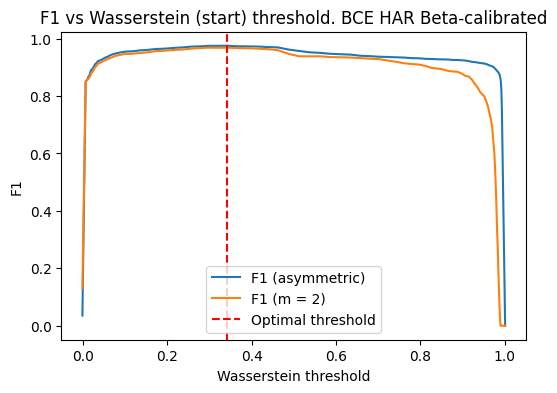

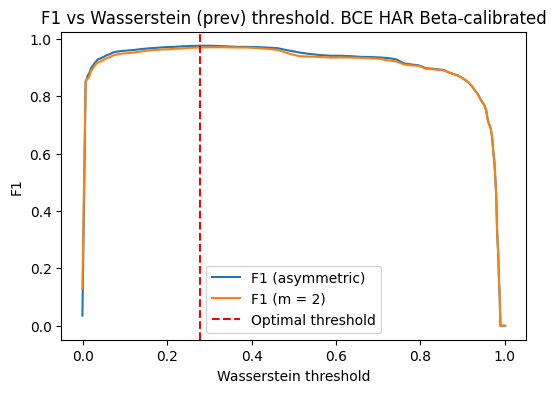

In [94]:
plt.figure(figsize=(6, 4))
plt.plot(f1_dict_start_cal.keys(), f1_dict_start_cal.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_start_cal.keys(), f1_m2_list_start_cal.values(), label="F1 (m = 2)")
plt.axvline(best_th_start_cal, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title("F1 vs Wasserstein (start) threshold. BCE HAR Beta-calibrated", fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_prev_cal.keys(), f1_dict_prev_cal.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_prev_cal.keys(), f1_m2_list_prev_cal.values(), label="F1 (m = 2)")
plt.axvline(best_th_prev_cal, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title("F1 vs Wasserstein (prev) threshold. BCE HAR Beta-calibrated", fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Explosions

In [3]:
from sklearn.model_selection import train_test_split

In [82]:
model_type = "seq2seq"

experiments_name = "explosion"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = (
    "saved_models/bce/explosion/layer_norm/train_anomaly_num_155/ens_1"
)

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [76]:
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cuda",
    verbose=False,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

res_start, best_th_start = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="start",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

res_prev, best_th_prev = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/102 [00:00<?, ?it/s]

Results for best threshold = 0.462193510926849
AUDC: 0.0, Time to FA: 15.5905, DD: 0.146, F1: 0.7097, Cover: 0.9815, Max Cover: 0.9815
Max F1 with margin 1: 0.2609
Max F1 with margin 2: 0.4615
Max F1 with margin 4: 0.6667


100%|██████████| 102/102 [01:29<00:00,  1.14it/s]

Results for best threshold = 0.2571936527643822
AUDC: 0.0, Time to FA: 15.619, DD: 0.1238, F1: 0.7586, Cover: 0.9854, Max Cover: 0.9854
Max F1 with margin 1: 0.56
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7586


In [77]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])
outs_tensor.shape, labels_tensor.shape

(torch.Size([10, 315, 16]), torch.Size([315, 16]))

In [78]:
torch.save(outs_tensor, "saved_outputs/bce/explosion/all_models_ens_1_outputs.pt")
torch.save(labels_tensor, "saved_outputs/bce/explosion/all_models_ens_1_labels.pt")

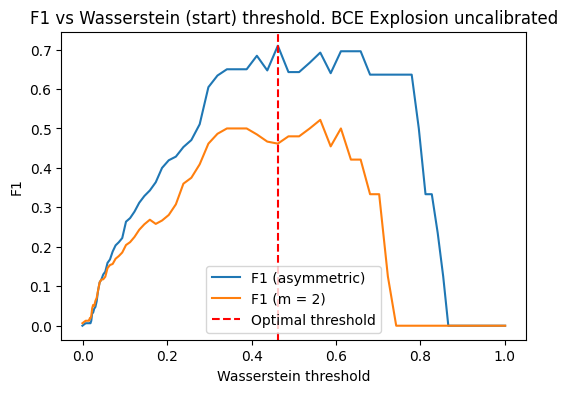

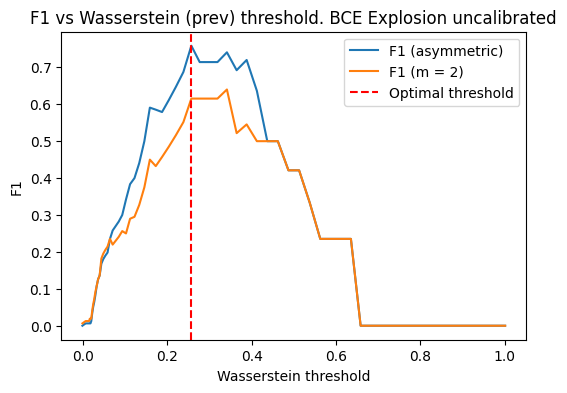

In [79]:
f1_dict_start = {th: v[3] for th, v in res_start.items()}
f1_m2_list_start = {th: v[6][2] for th, v in res_start.items()}

f1_dict_prev = {th: v[3] for th, v in res_prev.items()}
f1_m2_list_prev = {th: v[6][2] for th, v in res_prev.items()}

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_start.keys(), f1_dict_start.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_start.keys(), f1_m2_list_start.values(), label="F1 (m = 2)")
plt.axvline(best_th_start, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title(
    "F1 vs Wasserstein (start) threshold. BCE Explosion uncalibrated", fontsize=12
)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_prev.keys(), f1_dict_prev.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_prev.keys(), f1_m2_list_prev.values(), label="F1 (m = 2)")
plt.axvline(best_th_prev, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title("F1 vs Wasserstein (prev) threshold. BCE Explosion uncalibrated", fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [83]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    test_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cuda",
    verbose=True,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)

out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

res_start_cal, best_th_start_cal = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="start",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

res_prev_cal, best_th_prev_cal = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/102 [00:00<?, ?it/s]

Results for best threshold = 0.2205221270455694
AUDC: 0.0, Time to FA: 15.5397, DD: 0.1397, F1: 0.7222, Cover: 0.9806, Max Cover: 0.9806
Max F1 with margin 1: 0.2308
Max F1 with margin 2: 0.4667
Max F1 with margin 4: 0.6857


100%|██████████| 102/102 [01:46<00:00,  1.05s/it]

Results for best threshold = 0.18775768905482057
AUDC: 0.0, Time to FA: 15.6286, DD: 0.1365, F1: 0.7857, Cover: 0.9843, Max Cover: 0.9843
Max F1 with margin 1: 0.381
Max F1 with margin 2: 0.5833
Max F1 with margin 4: 0.8276


In [84]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])

torch.save(outs_tensor, "saved_outputs/bce/explosion/all_models_ens_1_outputs_cal.pt")
torch.save(labels_tensor, "saved_outputs/bce/explosion/all_models_ens_1_labels_cal.pt")

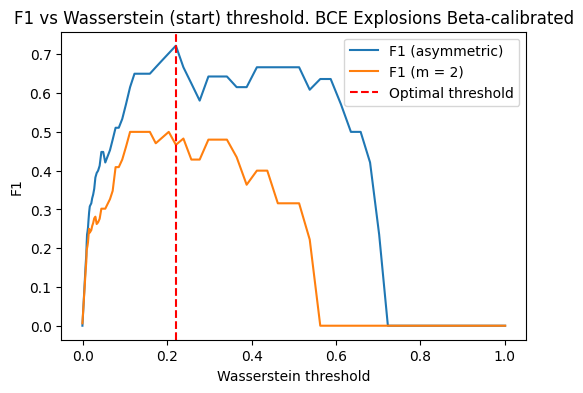

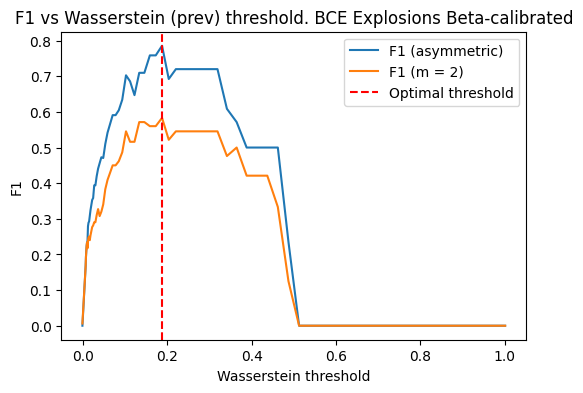

In [86]:
f1_dict_start_cal = {th: v[3] for th, v in res_start_cal.items()}
f1_m2_list_start_cal = {th: v[6][2] for th, v in res_start_cal.items()}

f1_dict_prev_cal = {th: v[3] for th, v in res_prev_cal.items()}
f1_m2_list_prev_cal = {th: v[6][2] for th, v in res_prev_cal.items()}

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_start_cal.keys(), f1_dict_start_cal.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_start_cal.keys(), f1_m2_list_start_cal.values(), label="F1 (m = 2)")
plt.axvline(best_th_start_cal, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title(
    "F1 vs Wasserstein (start) threshold. BCE Explosions Beta-calibrated", fontsize=12
)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_prev_cal.keys(), f1_dict_prev_cal.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_prev_cal.keys(), f1_m2_list_prev_cal.values(), label="F1 (m = 2)")
plt.axvline(best_th_prev_cal, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title(
    "F1 vs Wasserstein (prev) threshold. BCE Explosions Beta-calibrated", fontsize=12
)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Road Accidents

In [4]:
model_type = "seq2seq"

experiments_name = "explosion"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/road_accidents/layer_norm/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [5]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

In [4]:
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cuda",
    verbose=True,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

res_start, best_th_start = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="start",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

res_prev, best_th_prev = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/102 [00:00<?, ?it/s]

Results for best threshold = 0.462193510926849
AUDC: 0.0, Time to FA: 15.6063, DD: 0.1746, F1: 0.7097, Cover: 0.9805, Max Cover: 0.9805
Max F1 with margin 1: 0.1818
Max F1 with margin 2: 0.4615
Max F1 with margin 4: 0.6207


100%|██████████| 102/102 [01:24<00:00,  1.20it/s]

Results for best threshold = 0.29763488497442225
AUDC: 0.0, Time to FA: 15.6635, DD: 0.1333, F1: 0.7143, Cover: 0.9861, Max Cover: 0.9861
Max F1 with margin 1: 0.4348
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7586


In [5]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])
outs_tensor.shape, labels_tensor.shape

(torch.Size([10, 315, 16]), torch.Size([315, 16]))

In [6]:
torch.save(outs_tensor, "saved_outputs/bce/road_accidents/all_models_ens_1_outputs.pt")
torch.save(labels_tensor, "saved_outputs/bce/road_accidents/all_models_ens_1_labels.pt")

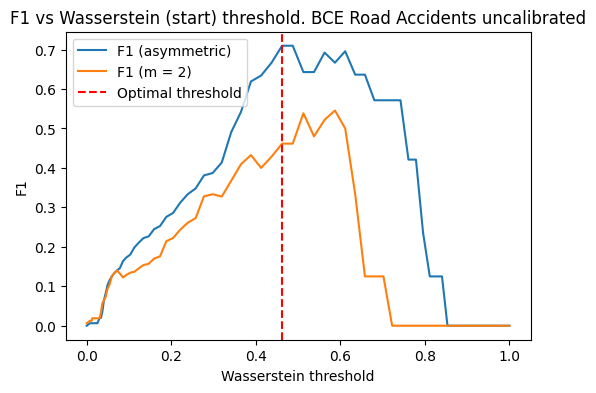

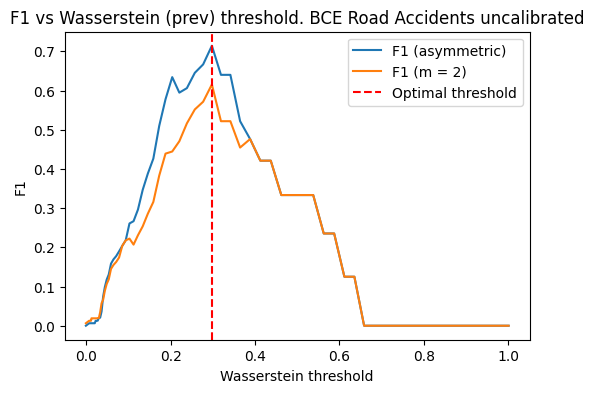

In [7]:
f1_dict_start = {th: v[3] for th, v in res_start.items()}
f1_m2_list_start = {th: v[6][2] for th, v in res_start.items()}

f1_dict_prev = {th: v[3] for th, v in res_prev.items()}
f1_m2_list_prev = {th: v[6][2] for th, v in res_prev.items()}

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_start.keys(), f1_dict_start.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_start.keys(), f1_m2_list_start.values(), label="F1 (m = 2)")
plt.axvline(best_th_start, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title(
    "F1 vs Wasserstein (start) threshold. BCE Road Accidents uncalibrated", fontsize=12
)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_prev.keys(), f1_dict_prev.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_prev.keys(), f1_m2_list_prev.values(), label="F1 (m = 2)")
plt.axvline(best_th_prev, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title(
    "F1 vs Wasserstein (prev) threshold. BCE Road Accidents uncalibrated", fontsize=12
)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [6]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    val_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cuda",
    verbose=True,
)

out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)

out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

res_start_cal, best_th_start_cal = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="start",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

res_prev_cal, best_th_prev_cal = evaluate_distance_ensemble_model(
    ens_model=ens_bce,
    threshold_list=threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    window_size=2,
    anchor_window_type="prev",
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/102 [00:00<?, ?it/s]

Results for best threshold = 0.7794778729544305
AUDC: 0.0, Time to FA: 15.6984, DD: 0.2, F1: 0.7143, Cover: 0.9817, Max Cover: 0.9817
Max F1 with margin 1: 0.1053
Max F1 with margin 2: 0.5
Max F1 with margin 4: 0.6154


100%|██████████| 102/102 [01:24<00:00,  1.21it/s]

Results for best threshold = 0.6354235592583607
AUDC: 0.0, Time to FA: 15.7333, DD: 0.1968, F1: 0.72, Cover: 0.9839, Max Cover: 0.9839
Max F1 with margin 1: 0.2222
Max F1 with margin 2: 0.5455
Max F1 with margin 4: 0.6087


In [9]:
outs_tensor = torch.hstack([out for out in test_out_bank])
labels_tensor = torch.vstack([labels for labels in test_labels_bank])

torch.save(
    outs_tensor, "saved_outputs/bce/road_accidents/all_models_ens_1_outputs_cal.pt"
)
torch.save(
    labels_tensor, "saved_outputs/bce/road_accidents/all_models_ens_1_labels_cal.pt"
)

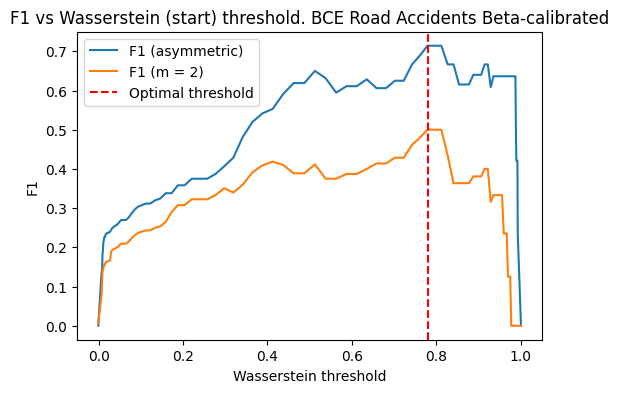

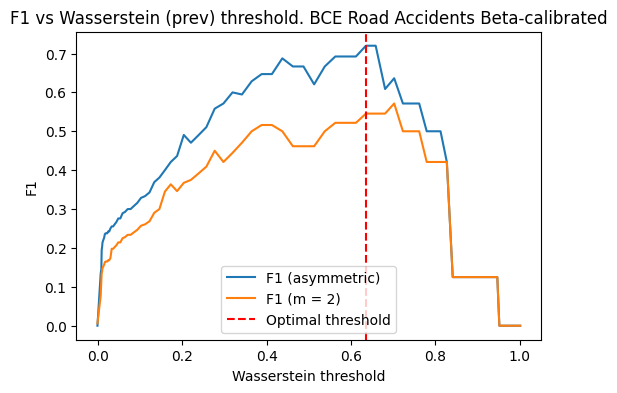

In [7]:
f1_dict_start_cal = {th: v[3] for th, v in res_start_cal.items()}
f1_m2_list_start_cal = {th: v[6][2] for th, v in res_start_cal.items()}

f1_dict_prev_cal = {th: v[3] for th, v in res_prev_cal.items()}
f1_m2_list_prev_cal = {th: v[6][2] for th, v in res_prev_cal.items()}

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_start_cal.keys(), f1_dict_start_cal.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_start_cal.keys(), f1_m2_list_start_cal.values(), label="F1 (m = 2)")
plt.axvline(best_th_start_cal, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title(
    "F1 vs Wasserstein (start) threshold. BCE Road Accidents Beta-calibrated",
    fontsize=12,
)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(f1_dict_prev_cal.keys(), f1_dict_prev_cal.values(), label="F1 (asymmetric)")
plt.plot(f1_m2_list_prev_cal.keys(), f1_m2_list_prev_cal.values(), label="F1 (m = 2)")
plt.axvline(best_th_prev_cal, c="r", linestyle="--", label="Optimal threshold")
plt.xlabel("Wasserstein threshold", fontsize=10)
plt.ylabel("F1", fontsize=10)
plt.title(
    "F1 vs Wasserstein (prev) threshold. BCE Road Accidents Beta-calibrated",
    fontsize=12,
)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# CP scores histograms

In [13]:
import math

import numpy as np
from ot import wasserstein_1d
from src.metrics.metrics_utils import collect_model_predictions_on_set

In [50]:
# def get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# ):
#     normal_scores_list = []
#     cp_scores_list = []
#     trans_scores_list = []

#     for preds_mean, labels, preds_std in zip(
#         test_out_bank, test_labels_bank, test_uncertainties_bank
#     ):
#         cp_idxs_batch = labels.cpu().argmax(axis=1)

#         for cp_idx, mean_series in zip(cp_idxs_batch, preds_mean):
#             if cp_idx == 0:
#                 normal_scores_list.extend(mean_series.numpy().tolist())
#             elif cp_idx < half_window + 1:
#                 trans_slice = mean_series[: cp_idx + half_window]
#                 cp_slice = mean_series[cp_idx + half_window :]

#                 trans_scores_list.extend(trans_slice.numpy().tolist())
#                 cp_scores_list.extend(cp_slice.numpy().tolist())

#             else:
#                 normal_slice = mean_series[: cp_idx - half_window]
#                 trans_slice = mean_series[cp_idx - half_window : cp_idx + half_window]
#                 cp_slice = mean_series[cp_idx + half_window :]

#                 normal_scores_list.extend(normal_slice.numpy().tolist())
#                 trans_scores_list.extend(trans_slice.numpy().tolist())
#                 cp_scores_list.extend(cp_slice.numpy().tolist())

#     return normal_scores_list, cp_scores_list, trans_scores_list

In [9]:
def get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
):
    normal_scores_list = []
    cp_scores_list = []

    for preds_mean, labels, preds_std in zip(
        test_out_bank, test_labels_bank, test_uncertainties_bank
    ):
        cp_idxs_batch = labels.cpu().argmax(axis=1)

        for cp_idx, mean_series in zip(cp_idxs_batch, preds_mean):
            if cp_idx == 0:
                normal_scores_list.extend(mean_series.numpy().tolist())
            else:
                normal_slice = mean_series[:cp_idx]
                cp_slice = mean_series[cp_idx:]

                normal_scores_list.extend(normal_slice.numpy().tolist())
                cp_scores_list.extend(cp_slice.numpy().tolist())

    return normal_scores_list, cp_scores_list

# HAR

In [3]:
model_type = "seq2seq"

experiments_name = "human_activity"
path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/human_activity/full_sample/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [4]:
from sklearn.model_selection import train_test_split

In [16]:
_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

## Uncalibrated

In [10]:
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce, test_loader=test_dataloader, model_type="ensemble", device="cpu"
    )
)

# normal_scores_list, cp_scores_list, trans_scores_list = get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# )

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

 10%|▉         | 2/21 [00:00<00:01, 13.04it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 18.57it/s]


(15317, 11423)

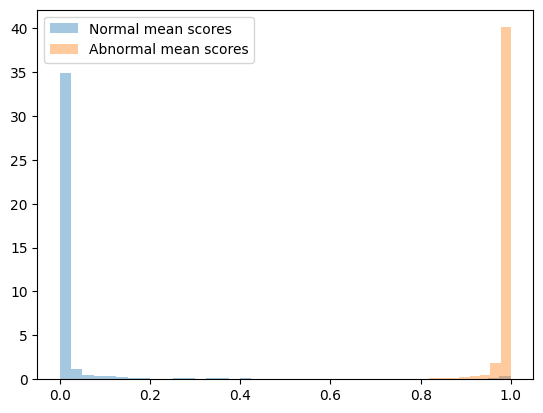

In [11]:
bins = 40
density = True

plt.figure()
plt.hist(
    normal_scores_list,
    bins=bins,
    density=density,
    label="Normal mean scores",
    alpha=0.4,
)
# plt.hist(
#     trans_scores_list,
#     bins=bins,
#     density=density,
#     label="Transitional mean scores",
#     alpha=0.5,
# )
plt.hist(
    cp_scores_list, bins=bins, density=density, label="Abnormal mean scores", alpha=0.4
)
plt.legend()
plt.show()

In [14]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

# base = np.random.choice(normal_scores_list, replace=True, size=30000)
# test = np.random.choice(cp_scores_list, replace=True, size=30000)

# kl = kl_div(torch.Tensor(base), torch.Tensor(test), reduction="mean")

# print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}, KL = {kl}")

print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}")

W_1 = 0.943, W_2 = 0.956


# Beta-calibrated

In [17]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    val_dataloader,
    cal_type="beta",
    verbose=False,
    device="cpu",
)

test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce, test_loader=test_dataloader, model_type="ensemble", device="cpu"
    )
)

# normal_scores_list, cp_scores_list, trans_scores_list = get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# )

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

 10%|▉         | 2/21 [00:00<00:01, 14.00it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 18.49it/s]


(15317, 11423)

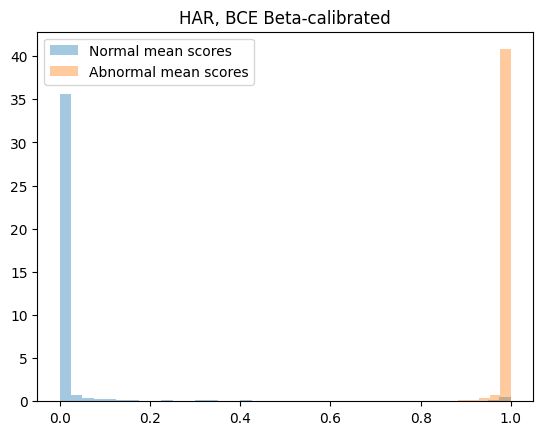

In [18]:
bins = 40
density = True

plt.figure()
plt.hist(
    normal_scores_list,
    bins=bins,
    density=density,
    label="Normal mean scores",
    alpha=0.4,
)
# plt.hist(
#     trans_scores_list,
#     bins=bins,
#     density=density,
#     label="Transitional mean scores",
#     alpha=0.5,
# )
plt.hist(
    cp_scores_list, bins=bins, density=density, label="Abnormal mean scores", alpha=0.4
)
plt.legend()
plt.title("HAR, BCE Beta-calibrated")
plt.show()

In [19]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

# base = np.random.choice(normal_scores_list, replace=True, size=30000)
# test = np.random.choice(cp_scores_list, replace=True, size=30000)

# kl = kl_div(torch.Tensor(base), torch.Tensor(test), reduction="mean")

# print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}, KL = {kl}")

print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}")

W_1 = 0.95, W_2 = 0.964


# Explosions

In [21]:
model_type = "seq2seq"

experiments_name = "explosion"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = (
    "saved_models/bce/explosion/layer_norm/train_anomaly_num_155/ens_1"
)

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [22]:
len(val_dataset), len(test_dataset)

(124, 315)

# Uncalibrated

In [13]:
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce, test_loader=test_dataloader, model_type="ensemble", device="cuda"
    )
)

# normal_scores_list, cp_scores_list, trans_scores_list = get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# )

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:41<00:00,  8.09s/it]


(4929, 111)

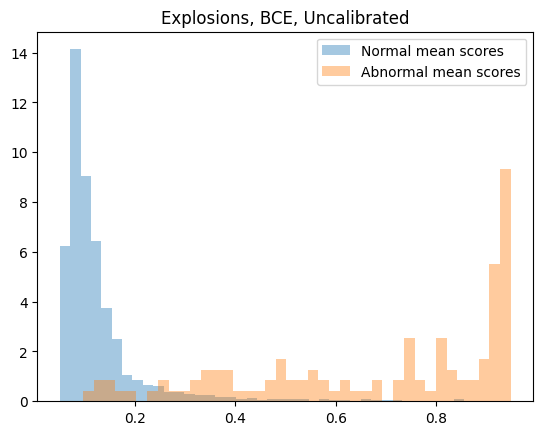

In [14]:
bins = 40
density = True

plt.figure()
plt.hist(
    normal_scores_list,
    bins=bins,
    density=density,
    label="Normal mean scores",
    alpha=0.4,
)
# plt.hist(
#     trans_scores_list,
#     bins=bins,
#     density=density,
#     label="Transitional mean scores",
#     alpha=0.5,
# )
plt.hist(
    cp_scores_list, bins=bins, density=density, label="Abnormal mean scores", alpha=0.4
)
plt.legend()
plt.title("Explosions, BCE, Uncalibrated")
plt.show()

In [15]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

# base = np.random.choice(normal_scores_list, replace=True, size=30000)
# test = np.random.choice(cp_scores_list, replace=True, size=30000)

# kl = kl_div(torch.Tensor(base), torch.Tensor(test), reduction="mean")

# print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}, KL = {kl}")

print(f"W_1 = {np.round(ws_1, 3)}, W_2 = {np.round(ws_2, 3)}")

W_1 = 0.547, W_2 = 0.591


# Beta-calibrated

In [23]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    val_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce,
        test_loader=test_dataloader,
        model_type="ensemble",
        device="cuda",
        verbose=True,
    )
)

# normal_scores_list, cp_scores_list, trans_scores_list = get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# )

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:40<00:00,  8.04s/it]


(4929, 111)

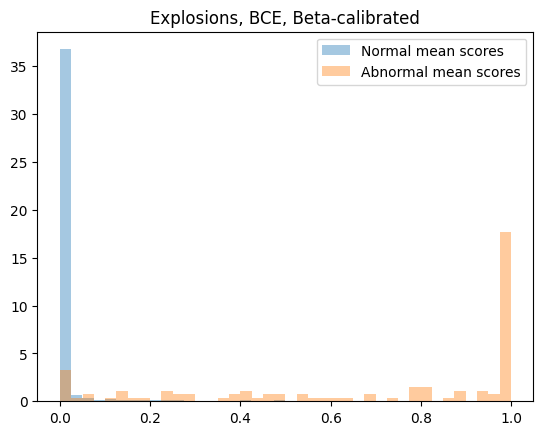

In [24]:
bins = 40
density = True

plt.figure()
plt.hist(
    normal_scores_list,
    bins=bins,
    density=density,
    label="Normal mean scores",
    alpha=0.4,
)
# plt.hist(
#     trans_scores_list,
#     bins=bins,
#     density=density,
#     label="Transitional mean scores",
#     alpha=0.5,
# )
plt.hist(
    cp_scores_list, bins=bins, density=density, label="Abnormal mean scores", alpha=0.4
)
plt.legend()
plt.title("Explosions, BCE, Beta-calibrated")
plt.show()

In [25]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(ws_1, ws_2)

0.6681358109266425 0.7578704251192953


# Metrics

In [29]:
from src.metrics.evaluation_pipelines import (
    all_cusums_evaluation_pipeline,
    all_distances_evaluation_pipeline,
    evaluation_pipeline,
)
from src.metrics.metrics_utils import compute_stds

In [27]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cuda",
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:40<00:00,  8.05s/it]


TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 187, FP: 120, FN: 0, TP: 8, DELAY:0.02222222276031971, FP_DELAY:13.4984130859375, COVER: 0.9122379136516041
TN: 190, FP: 117, FN: 0, TP: 8, DELAY:0.02222222276031971, FP_DELAY:13.539682388305664, COVER: 0.9141390680527586
TN: 195, FP: 112, FN: 0, TP: 8, DELAY:0.02222222276031971, FP_DELAY:13.644444465637207, COVER: 0.9155279569416475
TN: 197, FP: 110, FN: 0, TP: 8, DELAY:0.02222222276031971, FP_DELAY:13.711111068725586, COVER: 0.9177369516506422
TN: 201, FP: 106, FN: 0, TP: 8, DELAY:0.02222222276031971, FP_DELAY:13.790475845336914, COVER: 0.9207131421268326
TN: 202, FP: 105, FN: 0, TP: 8, DELAY:0.02222222276031971, FP_DELAY:13.819047927856445, COVER: 0.9209115548252453
TN: 204, FP: 103, FN: 0, TP: 8, DELAY:0.02222222276031971, FP_DELAY:13.869841575622559, COVER: 0.9217052056188961
TN: 209, FP: 98, FN: 0, TP: 8, DELAY:0.02539682574570179, FP_DELAY:13.98730182647705, COVER: 0.9270788828675733
TN: 210, FP

In [28]:
# wasserstein
threshold_list = np.linspace(0, 1, 100)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    p=1,
    device="cuda",
    verbose=True,
    window_size_list=[1, 2, 3],
    margin_list=[1, 2, 4],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/100 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.888888888888889
AUDC: 0.0, Time to FA: 15.7365, DD: 0.1873, F1: 0.72, Cover: 0.9847, Max Cover: 0.9847
Max F1 with margin 1: 0.4
Max F1 with margin 2: 0.5455
Max F1 with margin 4: 0.6667
window_size = 1, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.4040404040404041
AUDC: 0.0, Time to FA: 15.6476, DD: 0.1333, F1: 0.7586, Cover: 0.9863, Max Cover: 0.9863
Max F1 with margin 1: 0.56
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7586
window_size = 2, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.5252525252525253
AUDC: 0.0, Time to FA: 15.5206, DD: 0.1333, F1: 0.7027, Cover: 0.98, Max Cover: 0.98
Max F1 with margin 1: 0.2222
Max F1 with margin 2: 0.5
Max F1 with margin 4: 0.7027
window_size = 2, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.43434343434343436
AUDC: 0.0, Time to FA: 15.6286, DD: 0.1365, F1: 0.7857, Cover: 0.9843, Max Cover: 0.9843
Max F1 with margin 1: 0.381
Max F1 with margin 2: 0.5833
Max F1 with margin 4: 0.8276
window_size = 3, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.797979797979798
AUDC: 0.0, Time to FA: 15.7778, DD: 0.2286, F1: 0.6957, Cover: 0.9819, Max Cover: 0.9819
Max F1 with margin 1: 0.0
Max F1 with margin 2: 0.0
Max F1 with margin 4: 0.5714
window_size = 3, anchor_window_type = prev


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]

Results for best threshold = 0.36363636363636365
AUDC: 0.0, Time to FA: 15.5778, DD: 0.1397, F1: 0.7742, Cover: 0.982, Max Cover: 0.982
Max F1 with margin 1: 0.2727
Max F1 with margin 2: 0.5385
Max F1 with margin 4: 0.7333


In [30]:
compute_stds(
    ens_bce,
    test_dataloader=test_dataloader,
    half_windows_list=[1, 2, 3],
    verbose=True,
    device="cuda",
);

  0%|          | 0/20 [00:00<?, ?it/s]

Computing model's outputs...


100%|██████████| 20/20 [02:42<00:00,  8.13s/it]


Half-window: 1
CP stds list:
Mean = 0.1266253775129968, number is 15
Normal stds list:
Mean = 0.021552116303553418, number is 314
p_val analytical = 0.01988356576144083, p_val permutational = 0.1474852514748525
No conclusion
--------------------------------------------------
Half-window: 2
CP stds list:
Mean = 0.11714603800046804, number is 15
Normal stds list:
Mean = 0.02131568685706205, number is 314
p_val analytical = 0.02683168640949713, p_val permutational = 0.15958404159584041
No conclusion
--------------------------------------------------
Half-window: 3
CP stds list:
Mean = 0.11786644121492967, number is 15
Normal stds list:
Mean = 0.021097527707730185, number is 314
p_val analytical = 0.023662063262750374, p_val permutational = 0.14778522147785222
No conclusion
--------------------------------------------------


In [33]:
# cusums
ens_bce.args["cusum"] = {}
ens_bce.args["cusum"]["normal_sigma"] = 0.0216
ens_bce.args["cusum"]["cp_sigma"] = 0.1266
ens_bce.args["cusum"]["half_window"] = 1

res_cusums = all_cusums_evaluation_pipeline(
    ens_bce,
    threshold_number=300,
    test_dataloader=test_dataloader,
    margin_list=[1, 2, 4],
    device="cuda",
    verbose=True,
    min_th_quant=0.0,
    max_th_quant=1.0,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/300 [00:00<?, ?it/s]

Evaluating CUSUM model with cusum_mode = old and conditional = True
Threshold range: (0.0, 43.68284225463867)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 5.989954957993931
AUDC: 0.0, Time to FA: 15.7587, DD: 0.1905, F1: 0.6667, Cover: 0.9881, Max Cover: 0.9881
Max F1 with margin 1: 0.5
Max F1 with margin 2: 0.56
Max F1 with margin 4: 0.6667
Evaluating CUSUM model with cusum_mode = correct and conditional = False
Threshold range: (0.0, 11724.5869140625)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 1646.9319411057693
AUDC: 0.0, Time to FA: 15.6762, DD: 0.1778, F1: 0.6897, Cover: 0.9829, Max Cover: 0.9829
Max F1 with margin 1: 0.4167
Max F1 with margin 2: 0.48
Max F1 with margin 4: 0.6897
Evaluating CUSUM model with cusum_mode = correct and conditional = True
Threshold range: (0.0, 758374.625)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 2536.369983277592
AUDC: 0.0, Time to FA: 15.781, DD: 0.2127, F1: 0.6667, Cover: 0.9864, Max Cover: 0.9864
Max F1 with margin 1: 0.4762
Max F1 with margin 2: 0.5455
Max F1 with margin 4: 0.6667
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = False
Threshold range: (0.0, 10300.0068359375)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 1722.4091698892141
AUDC: 0.0, Time to FA: 15.5746, DD: 0.1556, F1: 0.6857, Cover: 0.9812, Max Cover: 0.9812
Max F1 with margin 1: 0.3571
Max F1 with margin 2: 0.4667
Max F1 with margin 4: 0.6857
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = True
Threshold range: (0.0, 758453.125)


100%|██████████| 300/300 [03:25<00:00,  1.46it/s]

Results for best threshold = 2536.632525083612
AUDC: 0.0, Time to FA: 15.781, DD: 0.2127, F1: 0.6667, Cover: 0.9864, Max Cover: 0.9864
Max F1 with margin 1: 0.4762
Max F1 with margin 2: 0.5455
Max F1 with margin 4: 0.6667


# Road Accidents

In [34]:
model_type = "seq2seq"

experiments_name = "explosion"
path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"
path_to_models_folder = "saved_models/bce/road_accidents/layer_norm/ens_1"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

_, val_dataset = train_test_split(train_dataset, test_size=0.4, random_state=42)
val_dataloader = DataLoader(
    val_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

## Uncalibrated

In [20]:
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce, test_loader=test_dataloader, model_type="ensemble", device="cuda"
    )
)

# normal_scores_list, cp_scores_list, trans_scores_list = get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# )

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


 20%|██        | 4/20 [00:33<02:15,  8.48s/it]

100%|██████████| 20/20 [02:46<00:00,  8.31s/it]


(4929, 111)

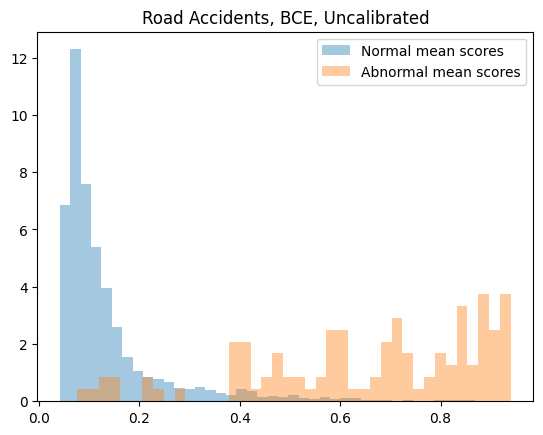

In [21]:
bins = 40
density = True

plt.figure()
plt.hist(
    normal_scores_list,
    bins=bins,
    density=density,
    label="Normal mean scores",
    alpha=0.4,
)
# plt.hist(
#     trans_scores_list,
#     bins=bins,
#     density=density,
#     label="Transitional mean scores",
#     alpha=0.5,
# )
plt.hist(
    cp_scores_list, bins=bins, density=density, label="Abnormal mean scores", alpha=0.4
)
plt.legend()
plt.title("Road Accidents, BCE, Uncalibrated")
plt.show()

In [22]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(ws_1, ws_2)

0.5213028254725762 0.5505003084692456


## Beta-calibrated

In [35]:
cal_models_list = calibrate_all_models_in_ensemble(
    ens_bce,
    val_dataloader,
    cal_type="beta",
    verbose=True,
    device="cuda",
)

test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        model=ens_bce,
        test_loader=test_dataloader,
        model_type="ensemble",
        device="cuda",
        verbose=True,
    )
)

# normal_scores_list, cp_scores_list, trans_scores_list = get_scores_collections(
#     test_out_bank, test_labels_bank, test_uncertainties_bank, half_window=1
# )

normal_scores_list, cp_scores_list = get_scores_collections_binary(
    test_out_bank, test_labels_bank, test_uncertainties_bank
)

len(normal_scores_list), len(cp_scores_list)

  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/8 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:47<00:00,  8.38s/it]


(4929, 111)

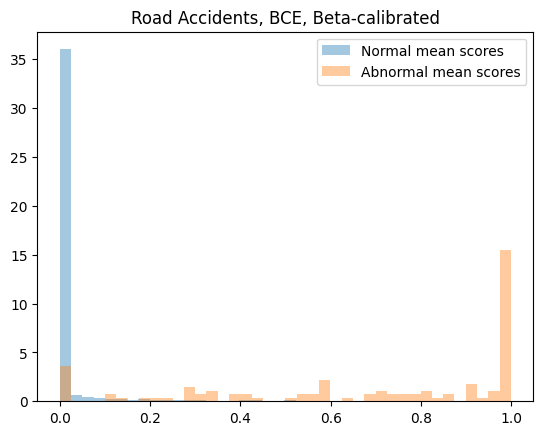

In [36]:
bins = 40
density = True

plt.figure()
plt.hist(
    normal_scores_list,
    bins=bins,
    density=density,
    label="Normal mean scores",
    alpha=0.4,
)
# plt.hist(
#     trans_scores_list,
#     bins=bins,
#     density=density,
#     label="Transitional mean scores",
#     alpha=0.5,
# )
plt.hist(
    cp_scores_list, bins=bins, density=density, label="Abnormal mean scores", alpha=0.4
)
plt.legend()
plt.title("Road Accidents, BCE, Beta-calibrated")
plt.show()

In [37]:
ws_1 = wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=1)

ws_2 = math.sqrt(
    wasserstein_1d(np.array(normal_scores_list), np.array(cp_scores_list), p=2)
)

print(ws_1, ws_2)

0.6637315688685312 0.7437181826153959


In [38]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cuda",
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:47<00:00,  8.35s/it]


TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 142, FP: 169, FN: 0, TP: 4, DELAY:0.012698412872850895, FP_DELAY:9.326984405517578, COVER: 0.9390823019022423
TN: 150, FP: 160, FN: 0, TP: 5, DELAY:0.01587301678955555, FP_DELAY:9.974602699279785, COVER: 0.937644185620376
TN: 158, FP: 152, FN: 0, TP: 5, DELAY:0.01587301678955555, FP_DELAY:10.7396821975708, COVER: 0.931683537472228
TN: 163, FP: 146, FN: 0, TP: 6, DELAY:0.02539682574570179, FP_DELAY:11.038095474243164, COVER: 0.9282056765985338
TN: 171, FP: 138, FN: 0, TP: 6, DELAY:0.02539682574570179, FP_DELAY:11.561904907226562, COVER: 0.9240531822674679
TN: 175, FP: 134, FN: 0, TP: 6, DELAY:0.02539682574570179, FP_DELAY:11.701587677001953, COVER: 0.9252436584579441
TN: 182, FP: 127, FN: 0, TP: 6, DELAY:0.02539682574570179, FP_DELAY:12.060317039489746, COVER: 0.9270293727436584
TN: 185, FP: 124, FN: 0, TP: 6, DELAY:0.02539682574570179, FP_DELAY:12.273015975952148, COVER: 0.9268309600452457
TN: 186, FP:

In [39]:
# wasserstein
threshold_list = np.linspace(0, 1, 100)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    p=1,
    device="cuda",
    verbose=True,
    window_size_list=[1, 2, 3],
    margin_list=[1, 2, 4],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/100 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.9696969696969697
AUDC: 0.0, Time to FA: 15.819, DD: 0.2381, F1: 0.6957, Cover: 0.9848, Max Cover: 0.9848
Max F1 with margin 1: 0.125
Max F1 with margin 2: 0.5714
Max F1 with margin 4: 0.6364
window_size = 1, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.30303030303030304
AUDC: 0.0, Time to FA: 15.5841, DD: 0.1111, F1: 0.6471, Cover: 0.9849, Max Cover: 0.9849
Max F1 with margin 1: 0.4667
Max F1 with margin 2: 0.5161
Max F1 with margin 4: 0.6857
window_size = 2, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.7777777777777778
AUDC: 0.0, Time to FA: 15.6984, DD: 0.2, F1: 0.7143, Cover: 0.9817, Max Cover: 0.9817
Max F1 with margin 1: 0.1053
Max F1 with margin 2: 0.5
Max F1 with margin 4: 0.6154
window_size = 2, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.6262626262626263
AUDC: 0.0, Time to FA: 15.7333, DD: 0.1968, F1: 0.72, Cover: 0.9839, Max Cover: 0.9839
Max F1 with margin 1: 0.2222
Max F1 with margin 2: 0.5455
Max F1 with margin 4: 0.6087
window_size = 3, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.494949494949495
AUDC: 0.0, Time to FA: 15.5175, DD: 0.1524, F1: 0.7027, Cover: 0.9777, Max Cover: 0.9777
Max F1 with margin 1: 0.08
Max F1 with margin 2: 0.4516
Max F1 with margin 4: 0.6286
window_size = 3, anchor_window_type = prev


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]

Results for best threshold = 0.43434343434343436
AUDC: 0.0, Time to FA: 15.5841, DD: 0.146, F1: 0.75, Cover: 0.9819, Max Cover: 0.9819
Max F1 with margin 1: 0.1818
Max F1 with margin 2: 0.4615
Max F1 with margin 4: 0.6667


In [40]:
compute_stds(
    ens_bce,
    test_dataloader=test_dataloader,
    half_windows_list=[1, 2, 3],
    verbose=True,
    device="cuda",
);

  0%|          | 0/20 [00:00<?, ?it/s]

Computing model's outputs...


100%|██████████| 20/20 [02:48<00:00,  8.44s/it]


Half-window: 1
CP stds list:
Mean = 0.14211477111137685, number is 15
Normal stds list:
Mean = 0.027584738140009488, number is 314
p_val analytical = 0.012156265259145229, p_val permutational = 0.0877912208779122
No conclusion
--------------------------------------------------
Half-window: 2
CP stds list:
Mean = 0.12690714067661282, number is 15
Normal stds list:
Mean = 0.027315313072752034, number is 314
p_val analytical = 0.02546884507035077, p_val permutational = 0.1090890910908909
No conclusion
--------------------------------------------------
Half-window: 3
CP stds list:
Mean = 0.12410089443199027, number is 15
Normal stds list:
Mean = 0.027096491212754818, number is 314
p_val analytical = 0.02252584471520483, p_val permutational = 0.10428957104289571
No conclusion
--------------------------------------------------


In [41]:
# cusums
ens_bce.args["cusum"] = {}
ens_bce.args["cusum"]["normal_sigma"] = 0.0276
ens_bce.args["cusum"]["cp_sigma"] = 0.1421
ens_bce.args["cusum"]["half_window"] = 1

res_cusums = all_cusums_evaluation_pipeline(
    ens_bce,
    threshold_number=300,
    test_dataloader=test_dataloader,
    margin_list=[1, 2, 4],
    device="cuda",
    verbose=True,
    min_th_quant=0.0,
    max_th_quant=1.0,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/300 [00:00<?, ?it/s]

Evaluating CUSUM model with cusum_mode = old and conditional = True
Threshold range: (0.0, 34.33478546142578)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 7.234419679163292
AUDC: 0.0, Time to FA: 15.7365, DD: 0.1937, F1: 0.6667, Cover: 0.9876, Max Cover: 0.9876
Max F1 with margin 1: 0.5
Max F1 with margin 2: 0.5
Max F1 with margin 4: 0.6154
Evaluating CUSUM model with cusum_mode = correct and conditional = False
Threshold range: (0.0, 5193.7021484375)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 1337.5085800323998
AUDC: 0.0, Time to FA: 15.6698, DD: 0.1937, F1: 0.7097, Cover: 0.9817, Max Cover: 0.9817
Max F1 with margin 1: 0.0952
Max F1 with margin 2: 0.4615
Max F1 with margin 4: 0.6207
Evaluating CUSUM model with cusum_mode = correct and conditional = True
Threshold range: (0.0, 448418.3125)


 55%|█████▌    | 165/300 [02:24<01:58,  1.14it/s]